In [1]:
import numpy as np
import torch 
import torch.nn as nn
import math 
import h5py
import yaml
import pickle
import sys
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


import src.models as models
import src.dataset as ds
import src.train_pcdae as train_pcdae
import src.inference_pcdae as inference
import src.data_preparation as data_prep

In [2]:

#### inference study

def get_model_dataset(seed, device, config):
    
    data_dict = data_prep.prepare_data_model(seed, "../" + config['data']["data_path"], config['training']["ratio_test_val_train"])

    X_test_scaled, y_test_scaled = data_dict['test']
    scaler_X, scaler_Y = data_dict['scalers']

    batch_size = X_test_scaled.shape[0]

    test_dataset = ds.LTPDataset(X_test_scaled, y_test_scaled)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    ###* define the PCDAE architecture
    x_dim = config['model']['x_dim']
    y_dim = config['model']['y_dim']
    hidden_dim = config['model']['hidden_dim']
        
    sigma_min = float(config['model']['sigma_min'])
    sigma_max = float(config['model']['sigma_max'])
        
    pcdae = models.PCDAE(x_dim=x_dim, y_dim=y_dim, hidden_dim=hidden_dim).to(device)
    pcdae.load_state_dict(torch.load(f"../models_saved/pcdae_inference_{seed}.pth"))
    
    return {
        'scalers': (scaler_X, scaler_Y),
        'data': (test_dataset, test_dataloader),
        'pcdae': pcdae,
        'sigmas': (sigma_min, sigma_max)
    }


In [3]:

config_file = "../config_pcdae.yaml"
seed = 1
device = torch.device('cpu')


try:
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Error: The file 'config.yaml' was not found.")
    exit()
except yaml.YAMLError as e:
    print(f"Error parsing YAML file: {e}")
    exit()
    


In [4]:
pcdae_dict = get_model_dataset(seed, device, config)

In [34]:
            
test_dataset, test_dataloader = pcdae_dict['data']
scaler_X, scaler_Y = pcdae_dict['scalers']
pcdae = pcdae_dict['pcdae']
sigma_min, sigma_max = pcdae_dict['sigmas']

nb_levels = 800
size_level = 20

noise_schedule = np.geomspace(sigma_max, sigma_min, nb_levels)
steps_vec = np.linspace(size_level, size_level, nb_levels, dtype=int)

test_init_loss = 0.0
test_refine_loss = 0.0
test_dual_loss = 0.0

y_evol = []
y_truth = []

for idx, seed in enumerate([1, 2, 3, 4, 5]):

    torch.manual_seed(seed)
    np.random.seed(seed)

    for i, (x, y) in enumerate(test_dataloader):
        
        y_init = torch.randn_like(y)
                    
        y_refined, y_aux = inference.inference_PCDAE_base_evolution(pcdae, x, y_init, noise_schedule, \
                                        steps_vec=steps_vec, step_size=0.01, eps_conv=1e-4, eps_clip=5e-1)
        
        y_truth.append(y)
        y_evol.append(y_aux)
    
    print("i: ", (idx+1)/5)

i:  0.2
i:  0.4
i:  0.6
i:  0.8
i:  1.0


In [41]:
y_truth_arr = np.array(y_truth)
y_evol_arr = np.array(y_evol).transpose(1, 0, 2, 3)

In [46]:

y_evol_mod_arr = y_evol_arr.reshape(800, 5*315, 17)
y_truth_mod_arr = y_truth_arr.reshape(1, 5*315, 17)


In [48]:
print(y_evol_mod_arr.shape)
print(y_truth_mod_arr.shape)

(800, 1575, 17)
(1, 1575, 17)


In [49]:
print(y_evol_arr.shape)
print(y_truth_arr.shape)


error_evol_arr = np.abs(y_evol_mod_arr - y_truth_mod_arr)
print(error_evol_arr.shape)

mean_evol_arr = np.mean(error_evol_arr, axis=1)
std_evol_arr = np.std(error_evol_arr, axis=1)

(800, 5, 315, 17)
(5, 315, 17)
(800, 1575, 17)


In [51]:
print(mean_evol_arr.shape)

(800, 17)


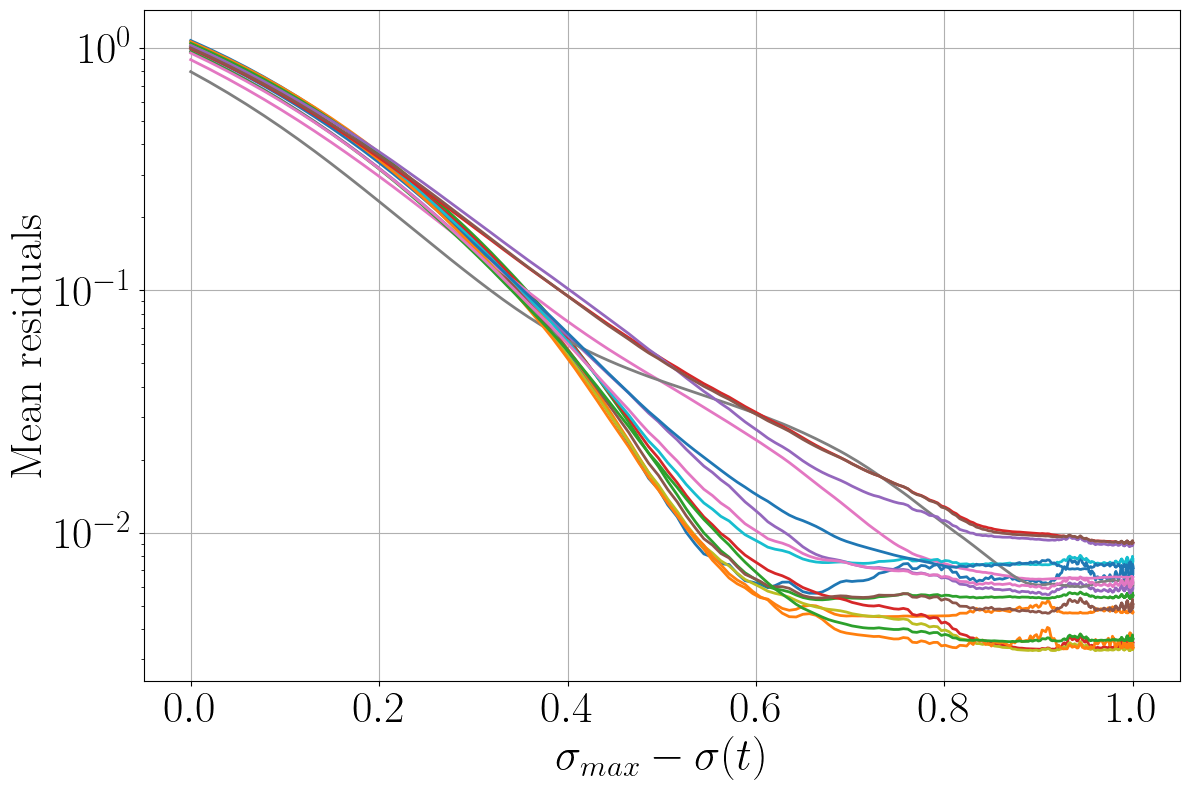

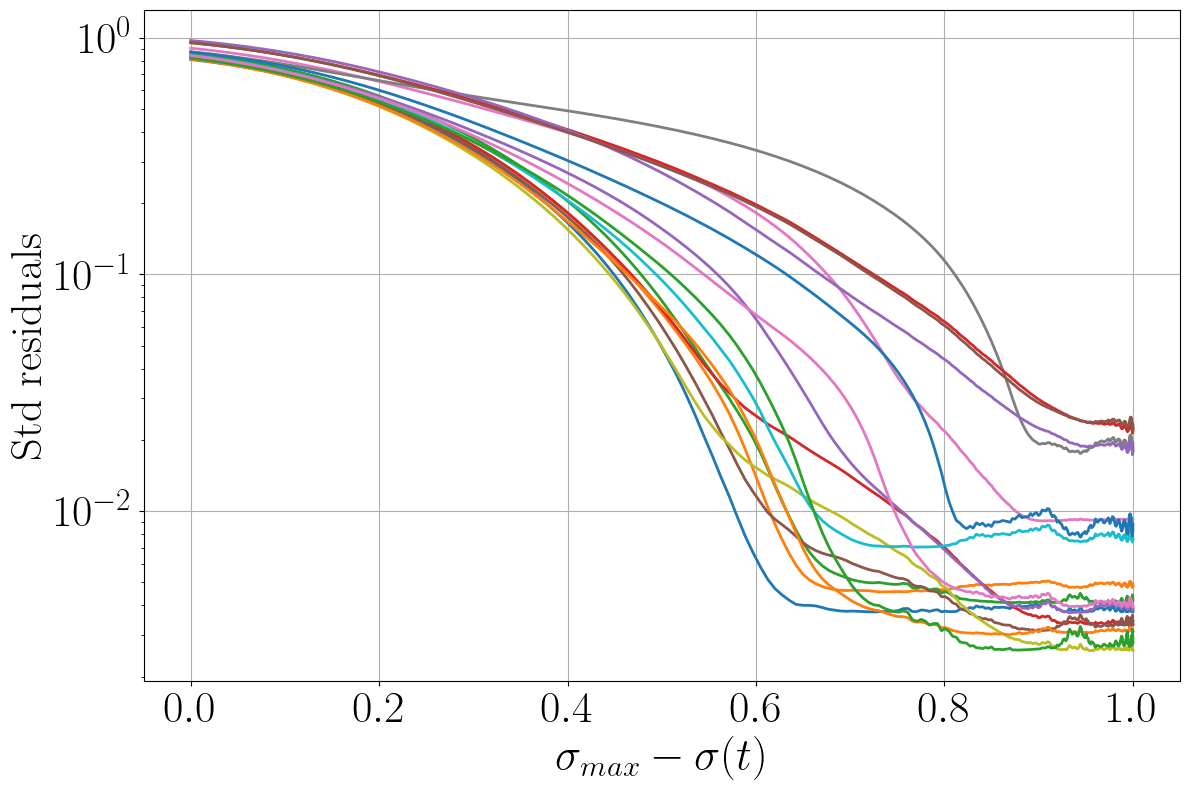

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(1-noise_schedule, mean_evol_arr, linewidth=2)
# plt.plot(noise_schedule, std_evol_arr)
plt.yscale('log')
plt.xlabel(r'$\sigma_{max} - \sigma(t)$', fontsize=32)
plt.ylabel(r'Mean residuals', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
# plt.ylim(0.005, 0.09)
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig("mean_evolution_inference2.png")


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.plot(1-noise_schedule, std_evol_arr, linewidth=2)
# plt.plot(noise_schedule, std_evol_arr)
plt.yscale('log')
plt.xlabel(r'$\sigma_{max} - \sigma(t)$', fontsize=32)
plt.ylabel(r'Std residuals', fontsize=32)
# plt.ylabel(r'$T/\Lambda$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
# plt.ylim(0.005, 0.09)
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig("std_evolution_inference2.png")
